### Logistci Regression using Pytorch - CIFAR10 (with k fold Cross validation)###
1.Iswariya Manivannan<br>
2.Sathiya Ramesh

In [2]:
import torch
import skorch # A pytorch wrapper for using sklearn
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from skorch.callbacks import EpochScoring
from skorch import NeuralNetClassifier
from skorch import utils

%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np

torch.manual_seed(40)
torch.cuda.manual_seed(40)
np.random.seed(2)

In [3]:
# Normalizing the output PIL Image of Torchvision dataset from [0,1] to [-1,1]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transform)
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Function to separate the data in trainset/testset as images and labels
def dataloader(dataset):
    images_labels = zip(*dataset)
    images_labels = list(images_labels)
    X = list(images_labels[0])
    y = list(images_labels[1])
    images = np.stack(X, axis =0)
    labels = np.asarray(y)

    images = np.reshape(images, (-1, 32*32*3))
    print(images.shape)
    
    return images, labels

In [5]:
X_train, y_train = dataloader(trainset)
X_test, y_test = dataloader(testset)

(50000, 3072)
(10000, 3072)


In [6]:
# 2 layer Logistic Regression Model which has one Hidden layer with Relu activation and an Output layer
class LogisticRegression_model(nn.Module):
    
    def __init__(self, input_dim, output_dim, num_units):
        
        super(LogisticRegression_model, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, num_units)
        self.linear2 = nn.Linear(num_units, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [9]:
input_dim = 32*32*3
output_dim = 10  
num_units = 1024  # no of units in hidden layer 1
model = NeuralNetClassifier(module = LogisticRegression_model, module__input_dim = input_dim, module__output_dim = output_dim,
                            module__num_units = num_units, max_epochs = 30, lr = 0.0001, batch_size = 512,
                            criterion=nn.CrossEntropyLoss, device = 'cuda',
                            optimizer = optim.Adam, verbose =2) # Set verbose to 2 while running fit

In [10]:
estimator = model.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.8259       0.4228        1.6543  12.3749
      2        1.6089       0.4549        1.5695  11.4016
      3        1.5290       0.4711        1.5248  11.0095
      4        1.4729       0.4813        1.4930  11.0106
      5        1.4273       0.4926        1.4680  11.0906
      6        1.3877       0.4978        1.4474  11.2246
      7        1.3524       0.5027        1.4300  11.0013
      8        1.3204       0.5090        1.4159  11.0157
      9        1.2908       0.5138        1.4036  11.5520
     10        1.2633       0.5156        1.3932  11.6971
     11        1.2376       0.5186        1.3843  12.0652
     12        1.2132       0.5209        1.3765  13.4823
     13        1.1899       0.5224        1.3699  11.9662
     14        1.1676       0.5259        1.3643  12.5923
     15        1.1461       0.5274        1.3593  12.2929
     16       

In [8]:
# Getting predictions for testset data
y_pred = model.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f'Test set Accuracy : {accuracy*100}')

Test set Accuracy : 53.44


In [15]:
print(model.history[1].keys())

dict_keys(['batches', 'epoch', 'dur', 'train_loss', 'train_loss_best', 'valid_loss', 'valid_loss_best', 'valid_acc', 'valid_acc_best'])


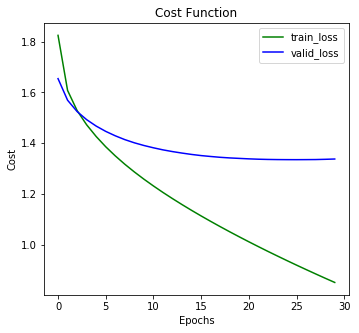

In [9]:
#Plotting learing curve
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.set_title("Cost Function")
ax.plot(model.history[:,'train_loss'], '-', color='green')
ax.plot(model.history[:,'valid_loss'], '-', color='blue')
ax.set_xlabel("Epochs")
ax.set_ylabel("Cost")
ax.legend(['train_loss', 'valid_loss'])


In [13]:
# Performing cross validation with a list of parameters in order to find the best ones
params = { 'lr': [0.001, 0.0001], 'module__num_units' : [512, 1024], 'max_epochs' : [20, 40] }
# Need to set verbose = 0 in model to prevent long outputs
estimator_cv = GridSearchCV(model, params, refit = True, cv =3, scoring = 'accuracy', verbose =2)
estimator_cv.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] lr=0.001, max_epochs=20, module__num_units=512 ..................
[CV] ... lr=0.001, max_epochs=20, module__num_units=512, total= 1.1min
[CV] lr=0.001, max_epochs=20, module__num_units=512 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] ... lr=0.001, max_epochs=20, module__num_units=512, total= 1.2min
[CV] lr=0.001, max_epochs=20, module__num_units=512 ..................
[CV] ... lr=0.001, max_epochs=20, module__num_units=512, total= 1.1min
[CV] lr=0.001, max_epochs=20, module__num_units=1024 .................
[CV] .. lr=0.001, max_epochs=20, module__num_units=1024, total= 1.3min
[CV] lr=0.001, max_epochs=20, module__num_units=1024 .................
[CV] .. lr=0.001, max_epochs=20, module__num_units=1024, total= 1.3min
[CV] lr=0.001, max_epochs=20, module__num_units=1024 .................
[CV] .. lr=0.001, max_epochs=20, module__num_units=1024, total= 1.3min
[CV] lr=0.001, max_epochs=40, module__num_units=512 ..................
[CV] ... lr=0.001, max_epochs=40, module__num_units=512, total= 2.3min
[CV] lr=0.001, max_epochs=40, module__num_units=512 ..................
[CV] ... lr=0.001, max_epochs=40, module__num_units=512, total= 2.2min
[CV] lr=0.001, max_epochs=40, module__num_units=512 ..................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 46.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=<class 'skorch.net.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.LogisticRegression_model'>,
  module__input_dim=3072,
  module__num_units=1024,
  module__output_dim=10,
),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lr': [0.001, 0.0001], 'module__num_units': [512, 1024], 'max_epochs': [20, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [17]:
print(f"Best Score: {estimator_cv.best_score_}    Best Params: {estimator_cv.best_params_}")

Best Score: 0.5188    Best Params: {'lr': 0.0001, 'max_epochs': 40, 'module__num_units': 1024}
